## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
# os.environ['HDF5_USE_FILE_LOCKING'] ='FALSE'

In [4]:
import pickle

import h5py
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
from torch.nn import functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from easydict import EasyDict as edict

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Utils

In [6]:
## UTILS

def load_vocab(cfg):
    def invert_dict(d):
        return {v: k for k, v in d.items()}

    with open(os.path.join(cfg.DATASET.DATA_DIR, 'dic.pkl'), 'rb') as f:
        dictionaries = pickle.load(f)
    vocab = {}
    vocab['question_token_to_idx'] = dictionaries["word_dic"]
    vocab['answer_token_to_idx'] = dictionaries["answer_dic"]
    vocab['question_token_to_idx']['pad'] = 0
    vocab['question_idx_to_token'] = invert_dict(vocab['question_token_to_idx'])
    vocab['answer_idx_to_token'] = invert_dict(vocab['answer_token_to_idx'])

    return vocab

def generateVarDpMask(shape, keepProb):
    randomTensor = torch.tensor(keepProb).cuda().expand(shape)
    randomTensor += nn.init.uniform_(torch.cuda.FloatTensor(shape[0], shape[1]))
    binaryTensor = torch.floor(randomTensor)
    mask = torch.cuda.FloatTensor(binaryTensor)
    return mask


def applyVarDpMask(inp, mask, keepProb):
    ret = (torch.div(inp, torch.tensor(keepProb).cuda())) * mask
    return ret

def init_modules(modules, w_init='kaiming_uniform'):
    if w_init == "normal":
        _init = init.normal_
    elif w_init == "xavier_normal":
        _init = init.xavier_normal_
    elif w_init == "xavier_uniform":
        _init = init.xavier_uniform_
    elif w_init == "kaiming_normal":
        _init = init.kaiming_normal_
    elif w_init == "kaiming_uniform":
        _init = init.kaiming_uniform_
    elif w_init == "orthogonal":
        _init = init.orthogonal_
    else:
        raise NotImplementedError
    for m in modules:
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            _init(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, (nn.LSTM, nn.GRU)):
            for name, param in m.named_parameters():
                if 'bias' in name:
                    nn.init.zeros_(param)
                elif 'weight' in name:
                    _init(param)

## DS

In [7]:
## DS

class ClevrDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, split='train'):

        with open(os.path.join(data_dir, '{}.pkl'.format(split)), 'rb') as f:
            self.data = pickle.load(f)
        self.img = h5py.File(os.path.join(data_dir, '{}_features.h5'.format(split)), 'r')['features'] # ['data']
        # self.img = h5py.File(os.path.join(data_dir, '{}_features.hdf5'.format(split)), 'r')['data']

    def __getitem__(self, index):
        imgfile, question, answer, family = self.data[index]
        id = int(imgfile.rsplit('_', 1)[1][:-4])
        img = torch.from_numpy(self.img[id])

        return img, question, len(question), answer, family

    def __len__(self):
        return len(self.data)


def collate_fn(batch):
    images, lengths, answers, _ = [], [], [], []
    batch_size = len(batch)

    max_len = max(map(lambda x: len(x[1]), batch))

    questions = np.zeros((batch_size, max_len), dtype=np.int64)
    sort_by_len = sorted(batch, key=lambda x: len(x[1]), reverse=True)

    for i, b in enumerate(sort_by_len):
        image, question, length, answer, family = b
        images.append(image)
        length = len(question)
        questions[i, :length] = question
        lengths.append(length)
        answers.append(answer)

    return {'image': torch.stack(images), 'question': torch.from_numpy(questions),
            'answer': torch.LongTensor(answers), 'question_length': lengths}

## MAC

In [16]:
## MAC

class ControlUnit(nn.Module):
    def __init__(self, cfg, module_dim, max_step=4):
        super().__init__()
        self.cfg = cfg
        self.attn = nn.Linear(module_dim, 1)
        self.control_input = nn.Sequential(nn.Linear(module_dim, module_dim),
                                           nn.Tanh())

        self.control_input_u = nn.ModuleList()
        for i in range(max_step):
            self.control_input_u.append(nn.Linear(module_dim, module_dim))
            
        self.module_dim = module_dim


    def mask(self, question_lengths, device):
        max_len = max(question_lengths)
        mask = torch.arange(max_len, device=device).expand(len(question_lengths), int(max_len)) < question_lengths.unsqueeze(1)
        mask = mask.float()
        ones = torch.ones_like(mask)
        mask = (ones - mask) * (1e-30)
        return mask

    @staticmethod
    def mask_by_length(x, lengths, device=None):
        lengths = torch.as_tensor(lengths, dtype=torch.float32, device=device)
        max_len = max(lengths)
        mask = torch.arange(max_len, device=device).expand(len(lengths), int(max_len)) < lengths.unsqueeze(1)
        mask = mask.float().unsqueeze(2)

        x_masked = x * mask + (1 - 1 / mask)
        
        return x_masked
    
    def forward(self, question, context, question_lengths, step):
        """
        Args:
            question: external inputs to control unit (the question vector).
                [batchSize, ctrlDim]
            context: the representation of the words used to compute the attention.
                [batchSize, questionLength, ctrlDim]
            control: previous control state
            question_lengths: the length of each question.
                [batchSize]
            step: which step in the reasoning chain
        """
        # compute interactions with question words
        question = self.control_input(question)
        question = self.control_input_u[step](question)

        newContControl = question
        newContControl = torch.unsqueeze(newContControl, 1)
        interactions = newContControl * context

        # compute attention distribution over words and summarize them accordingly
        logits = self.attn(interactions)
        
        print(question_lengths)
        # TODO: add mask again?!
        print('before', logits)
        logits = self.mask_by_length(logits, question_lengths, device=context.device)
        print('after', logits)
        attn = F.softmax(logits, 1)
        
        print(attn)
        
        # apply soft attention to current context words
        next_control = (attn * context).sum(1)

        return next_control

    
class ReadUnit(nn.Module):
    def __init__(self, module_dim):
        super().__init__()

        self.concat = nn.Linear(module_dim * 2, module_dim)
        self.concat_2 = nn.Linear(module_dim, module_dim)
        self.attn = nn.Linear(module_dim, 1)
        self.dropout = nn.Dropout(0.15)
        self.kproj = nn.Linear(module_dim, module_dim)
        self.mproj = nn.Linear(module_dim, module_dim)

        self.activation = nn.ELU()
        self.module_dim = module_dim

    def forward(self, memory, know, control, memDpMask=None):
        """
        Args:
            memory: the cell's memory state
                [batchSize, memDim]

            know: representation of the knowledge base (image).
                [batchSize, kbSize (Height * Width), memDim]

            control: the cell's control state
                [batchSize, ctrlDim]

            memDpMask: variational dropout mask (if used)
                [batchSize, memDim]
        """
        ## Step 1: knowledge base / memory interactions
        # compute interactions between knowledge base and memory
        know = self.dropout(know)
        if memDpMask is not None:
            if self.training:
                memory = applyVarDpMask(memory, memDpMask, 0.85)
        else:
            memory = self.dropout(memory)
        know_proj = self.kproj(know)
        memory_proj = self.mproj(memory)
        memory_proj = memory_proj.unsqueeze(1)
        interactions = know_proj * memory_proj

        # project memory interactions back to hidden dimension
        interactions = torch.cat([interactions, know_proj], -1)
        interactions = self.concat(interactions)
        interactions = self.activation(interactions)
        interactions = self.concat_2(interactions)

        ## Step 2: compute interactions with control
        control = control.unsqueeze(1)
        interactions = interactions * control
        interactions = self.activation(interactions)

        ## Step 3: sum attentions up over the knowledge base
        # transform vectors to attention distribution
        interactions = self.dropout(interactions)
        attn = self.attn(interactions).squeeze(-1)
        attn = F.softmax(attn, 1)

        # sum up the knowledge base according to the distribution
        attn = attn.unsqueeze(-1)
        # attn[:, border_idxs , 0] = 0
        read = (attn * know).sum(1)
        
        # print('control', control)
        # print('attn size', attn.size())
        # print('attn map')
        # print(attn.view(memory.size(0), 14, 14))
        # print('border size', attn[:, border_idxs , 0].size(), attn[:, border_idxs , 0].sum(dim=1))

        return read


class WriteUnit(nn.Module):
    def __init__(self, cfg, module_dim):
        super().__init__()
        self.cfg = cfg
        self.linear = nn.Linear(module_dim * 2, module_dim)

    def forward(self, memory, info):
        newMemory = torch.cat([memory, info], -1)
        newMemory = self.linear(newMemory)

        return newMemory


class MACUnit(nn.Module):
    def __init__(self, cfg, module_dim=512, max_step=4):
        super().__init__()
        self.cfg = cfg
        self.control = ControlUnit(cfg, module_dim, max_step)
        self.read = ReadUnit(module_dim)
        self.write = WriteUnit(cfg, module_dim)

        self.initial_memory = nn.Parameter(torch.zeros(1, module_dim))

        self.module_dim = module_dim
        self.max_step = max_step

    def zero_state(self, batch_size, question):
        initial_memory = self.initial_memory.expand(batch_size, self.module_dim)
        initial_control = question

        if self.cfg.TRAIN.VAR_DROPOUT:
            memDpMask = generateVarDpMask((batch_size, self.module_dim), 0.85)
        else:
            memDpMask = None

        return initial_control, initial_memory, memDpMask

    def forward(self, context, question, knowledge, question_lengths):
        batch_size = question.size(0)
        control, memory, memDpMask = self.zero_state(batch_size, question)

        for i in range(self.max_step):
            # control unit
            control = self.control(question, context, question_lengths, i)
            # read unit
            info = self.read(memory, knowledge, control, memDpMask)
            # write unit
            memory = self.write(memory, info)

        return memory


class InputUnit(nn.Module):
    def __init__(self, cfg, vocab_size, wordvec_dim=300, rnn_dim=512, module_dim=512, bidirectional=True):
        super(InputUnit, self).__init__()

        self.dim = module_dim
        self.cfg = cfg

        self.stem = nn.Sequential(nn.Dropout(p=0.18),
                                  nn.Conv2d(1024, module_dim, 3, 1, 1),
                                  nn.ELU(),
                                  nn.Dropout(p=0.18),
                                  nn.Conv2d(module_dim, module_dim, kernel_size=3, stride=1, padding=1),
                                  nn.ELU())

        self.bidirectional = bidirectional
        if bidirectional:
            rnn_dim = rnn_dim // 2

        self.encoder_embed = nn.Embedding(vocab_size, wordvec_dim)
        self.encoder = nn.LSTM(wordvec_dim, rnn_dim, batch_first=True, bidirectional=bidirectional)
        self.embedding_dropout = nn.Dropout(p=0.15)
        self.question_dropout = nn.Dropout(p=0.08)

    def forward(self, image, question, question_len):
        b_size = question.size(0)

        # get image features
        img = self.stem(image)
        img = img.view(b_size, self.dim, -1)
        img = img.permute(0,2,1)

        # get question and contextual word embeddings
        embed = self.encoder_embed(question)
        embed = self.embedding_dropout(embed)
        embed = nn.utils.rnn.pack_padded_sequence(embed, question_len, batch_first=True)

        contextual_words, (question_embedding, _) = self.encoder(embed)
        if self.bidirectional:
            question_embedding = torch.cat([question_embedding[0], question_embedding[1]], -1)
        question_embedding = self.question_dropout(question_embedding)

        contextual_words, _ = nn.utils.rnn.pad_packed_sequence(contextual_words, batch_first=True)

        return question_embedding, contextual_words, img


class OutputUnit(nn.Module):
    def __init__(self, module_dim=512, num_answers=28):
        super(OutputUnit, self).__init__()

        self.question_proj = nn.Linear(module_dim, module_dim)

        self.classifier = nn.Sequential(nn.Dropout(0.15),
                                        nn.Linear(module_dim * 2, module_dim),
                                        nn.ELU(),
                                        nn.Dropout(0.15),
                                        nn.Linear(module_dim, num_answers))

    def forward(self, question_embedding, memory):
        # apply classifier to output of MacCell and the question
        question_embedding = self.question_proj(question_embedding)
        out = torch.cat([memory, question_embedding], 1)
        out = self.classifier(out)

        return out


class MACNetwork(nn.Module):
    def __init__(self, cfg, max_step, vocab):
        super().__init__()

        self.cfg = cfg
        encoder_vocab_size = len(vocab['question_token_to_idx'])

        self.input_unit = InputUnit(cfg, vocab_size=encoder_vocab_size)

        self.output_unit = OutputUnit()

        self.mac = MACUnit(cfg, max_step=max_step)

        init_modules(self.modules(), w_init=self.cfg.TRAIN.WEIGHT_INIT)
        nn.init.uniform_(self.input_unit.encoder_embed.weight, -1.0, 1.0)
        nn.init.normal_(self.mac.initial_memory)

    def forward(self, image, question, question_len):
        # get image, word, and sentence embeddings
        question_embedding, contextual_words, img = self.input_unit(image, question, question_len)

        # apply MacCell
        memory = self.mac(contextual_words, question_embedding, img, question_len)

        # get classification
        out = self.output_unit(question_embedding, memory)

        return out

## Config

In [9]:
cfg = edict({
    'GPU_ID': '-1',
    'CUDA': False,
    'WORKERS': 4,
    'TRAIN': {'FLAG': True,
    'LEARNING_RATE': 0.0001,
    'BATCH_SIZE': 64,
    'MAX_EPOCHS': 25,
    'SNAPSHOT_INTERVAL': 5,
    'WEIGHT_INIT': 'xavier_uniform',
    'CLIP_GRADS': True,
    'CLIP': 8,
    'MAX_STEPS': 4,
    'EALRY_STOPPING': True,
    'PATIENCE': 5,
    'VAR_DROPOUT': False},
    'DATASET': {'DATA_DIR': '/Users/sebamenabar/Documents/datasets/CLEVR/data/'}
})
# cfg.ATTNS_PATH = '/home/samenabar/code/CLMAC/attn_preds.pth'

vocab = load_vocab(cfg)

In [10]:
ds = ClevrDataset(cfg.DATASET.DATA_DIR, split='val')

In [11]:
s = 14
border_idxs = list(range(s)) + list(range(s, s * s , s)) + list(range(2 * s - 1, s * s, s)) + list(range(s * (s - 1) + 1, s * s - 1))
print(border_idxs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 182, 27, 41, 55, 69, 83, 97, 111, 125, 139, 153, 167, 181, 195, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]


### Test run

In [17]:
loader = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=False, collate_fn=collate_fn)
b = next(iter(loader))

model = MACNetwork(cfg=cfg, max_step=4, vocab=vocab)
model.load_state_dict(torch.load('/Users/sebamenabar/Documents/vanilla_mac.pth', map_location='cpu')['model'], strict=False)
model(b['image'], b['question'], b['question_length']);

[16, 15]
before tensor([[[-0.2854],
         [-1.0899],
         [-1.5652],
         [-1.1826],
         [-2.5759],
         [-2.0687],
         [-2.5603],
         [-1.0824],
         [-0.3745],
         [-0.1980],
         [ 1.0949],
         [ 0.3896],
         [-1.9553],
         [-2.4066],
         [-2.0203],
         [ 1.1258]],

        [[-1.0094],
         [-2.3409],
         [-2.3608],
         [-2.5388],
         [-2.3903],
         [-1.7581],
         [-0.7624],
         [-1.0497],
         [-0.0591],
         [-0.1435],
         [ 1.7898],
         [ 0.7067],
         [-1.2774],
         [-1.3297],
         [ 1.2966],
         [ 0.0417]]], grad_fn=<AddBackward0>)
after tensor([[[-0.2854],
         [-1.0899],
         [-1.5652],
         [-1.1826],
         [-2.5759],
         [-2.0687],
         [-2.5603],
         [-1.0824],
         [-0.3745],
         [-0.1980],
         [ 1.0949],
         [ 0.3896],
         [-1.9553],
         [-2.4066],
         [-2.0203],
         [

In [81]:
attn_map = [[4.6691e-02, 3.2337e-02, 2.0634e-05, 2.0371e-05, 1.1608e-03,
          8.4321e-04, 1.6840e-03, 3.5990e-03, 8.0386e-04, 1.0109e-03,
          8.5973e-03, 2.1343e-02, 4.6209e-02, 3.2470e-02],
         [4.2740e-03, 1.4435e-07, 3.6884e-10, 4.1623e-08, 4.7735e-09,
          5.0723e-07, 1.1788e-05, 1.6316e-06, 2.7271e-06, 2.2080e-08,
          7.4431e-09, 2.4579e-10, 3.9166e-09, 2.7399e-05],
         [8.3788e-03, 2.1952e-07, 3.9957e-11, 3.7963e-08, 2.0358e-07,
          2.5241e-06, 1.1836e-06, 1.1163e-06, 9.7851e-04, 4.5350e-06,
          1.7296e-08, 6.5078e-07, 1.3929e-06, 6.4927e-05],
         [1.1556e-02, 1.7276e-08, 2.2465e-10, 5.8126e-07, 5.7015e-06,
          2.2113e-05, 6.5652e-08, 5.2176e-04, 5.9176e-02, 3.2347e-03,
          2.0555e-09, 1.0285e-08, 2.6630e-06, 3.9975e-04],
         [5.9400e-03, 6.7348e-07, 1.2308e-06, 6.5737e-06, 7.2962e-06,
          3.0436e-06, 1.6371e-06, 2.4223e-02, 8.4673e-02, 5.8390e-02,
          2.2813e-05, 8.7826e-07, 1.8601e-06, 1.6323e-04],
         [5.6706e-03, 4.0654e-07, 4.4115e-04, 8.0436e-06, 1.1187e-06,
          3.7649e-08, 2.0688e-06, 3.8704e-02, 9.1535e-02, 7.0090e-02,
          7.0944e-05, 5.2552e-08, 2.3616e-08, 1.8128e-05],
         [2.4666e-02, 1.7546e-05, 1.3802e-04, 2.3359e-07, 1.4394e-05,
          7.9395e-06, 6.1499e-06, 2.2857e-04, 4.9503e-02, 5.7929e-05,
          1.3919e-09, 2.0289e-09, 6.3028e-10, 3.2174e-06],
         [2.3189e-02, 9.0846e-07, 2.9632e-06, 3.5244e-09, 1.3327e-04,
          5.9674e-04, 4.9125e-06, 5.2291e-06, 1.0562e-06, 6.2003e-06,
          5.1570e-07, 1.8879e-09, 1.5624e-12, 1.4849e-05],
         [2.0369e-02, 7.9596e-07, 1.1097e-08, 7.9483e-08, 3.5026e-05,
          5.2937e-06, 9.3080e-08, 7.6669e-05, 4.4044e-05, 1.9410e-04,
          2.7675e-05, 1.4260e-05, 9.5856e-09, 1.2191e-05],
         [1.4049e-02, 3.5797e-09, 7.9195e-09, 6.6095e-08, 2.5213e-06,
          2.0561e-08, 2.7681e-08, 8.3026e-05, 3.6005e-06, 1.2087e-04,
          2.5960e-06, 1.7023e-06, 6.8962e-11, 5.5342e-05],
         [1.2303e-02, 1.3562e-08, 3.3031e-07, 1.9024e-08, 9.5817e-06,
          6.4230e-05, 1.3678e-06, 2.4997e-06, 3.9915e-07, 8.3822e-05,
          3.3779e-04, 7.0598e-08, 1.3485e-07, 2.8645e-04],
         [7.5054e-03, 2.0360e-08, 6.6605e-08, 5.6123e-08, 3.2117e-07,
          4.6107e-04, 7.2762e-04, 1.3024e-08, 2.4400e-09, 9.2870e-10,
          2.4170e-11, 4.0269e-10, 3.5427e-07, 5.4575e-05],
         [2.2740e-02, 3.1932e-05, 3.4172e-08, 8.0471e-07, 4.1517e-09,
          9.8876e-08, 3.3200e-09, 8.6426e-09, 4.0269e-08, 7.5779e-08,
          3.9030e-10, 7.9336e-10, 1.8382e-05, 1.8047e-02],
         [8.1103e-02, 8.5719e-04, 3.3199e-03, 3.4654e-03, 2.8527e-03,
          3.5556e-03, 4.1703e-04, 7.6095e-04, 2.0141e-03, 5.1201e-03,
          3.2624e-03, 5.1950e-04, 7.6894e-03, 2.3246e-02]]

attn_map = np.array(attn_map)

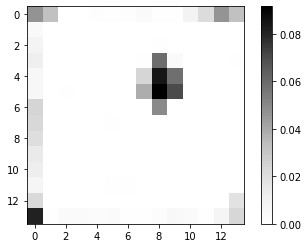

In [82]:
plt.imshow(np.array(attn_map), cmap='Greys')
plt.colorbar()

## Eval

In [14]:
model = model.to(device)

In [88]:
model.eval()
with torch.no_grad():
    pbar = tqdm(loader, total=len(loader))
    total_accuracy = 0.
    total_samples = 0
    for data in pbar:

        image, question, question_len, answer = data['image'], data['question'], data['question_length'], data['answer']
        answer = answer.long()

        image = image.to(device)
        question = question.to(device)
        answer = answer.to(device)
        
        with torch.no_grad():
            scores = model(image, question, question_len)
            # scores_ema = self.model_ema(image, question, question_len)

        # correct_ema = scores_ema.detach().argmax(1) == answer
        # accuracy_ema = correct_ema.sum().cpu().numpy() / answer.shape[0]
        # all_accuracies_ema.append(accuracy_ema)

        correct = scores.detach().argmax(1) == answer
        accuracy = correct.sum().cpu().numpy() / answer.shape[0]
        # all_accuracies.append(accuracy)
        total_accuracy += (accuracy * image.size(0))
        total_samples += image.size(0)
        
        pbar.set_postfix(avg_accuracy=total_accuracy / total_samples)

        # accuracy_ema = sum(all_accuracies_ema) / float(len(all_accuracies_ema))
# accuracy = sum(all_accuracies) / float(len(all_accuracies))

# accuracy

attn map
border size torch.Size([64, 52]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
attn map
border size torch.Size([64, 52]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
attn map
border size torch.Size([64, 52]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
attn map
border size torch.Size

KeyboardInterrupt: 